<a href="https://colab.research.google.com/github/nseudondian/Auto-message-with-python/blob/master/Recommendation_Systems_Learner_Notebook_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163006 sha256=b3c5412714d8ff5e43b7cefdb6ed0b5b4988975478bcfc357bba229c5a80595f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [5]:
import warnings                                 # ignores the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [6]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None) #No headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names  ['user_id', 'prod_id', 'rating', 'timestamp']

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [7]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [9]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [11]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations

rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)


No of rows:  65290
No of columns:  3


**Write your observations here: There are 65290 rows and 3 columns**

### **Data types**

In [15]:
# Check Data types and provide observations
data_types = df_final.dtypes

# Print data types of columns
print("Data types of columns:")
print(data_types)

Data types of columns:
user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here:user_id and prod_id are objects, while rating column contains floating-point numbers**

### **Checking for missing values**

In [16]:
# Check for missing values present and provide observations

missing_values = df_final.isnull().sum()

# Print missing values
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
user_id    0
prod_id    0
rating     0
dtype: int64


**Write your observations here:There are no missing values**

### **Summary Statistics**

In [18]:
# Summary statistics of 'rating' variable and provide observations

rating_summary = df_final['rating'].describe().round(2)

# Print summary statistics
print("Summary statistics of 'rating' variable:")
print(rating_summary)


Summary statistics of 'rating' variable:
count    65290.00
mean         4.29
std          0.99
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: rating, dtype: float64


**Write your observations here:______**

Count: Number of non-missing values in the 'rating' variable is 65290.
Mean: Average rating across all observations is 4.29
Standard deviation: Measure of the dispersion of ratings around the mean is 0.99
Minimum: Minimum rating observed is 1.00
25th percentile (Q1): 4.00
Median (50th percentile or Q2): 5.00
75th percentile (Q3): 5.00
Maximum: Maximum rating observed. is 5.00

### **Checking the rating distribution**

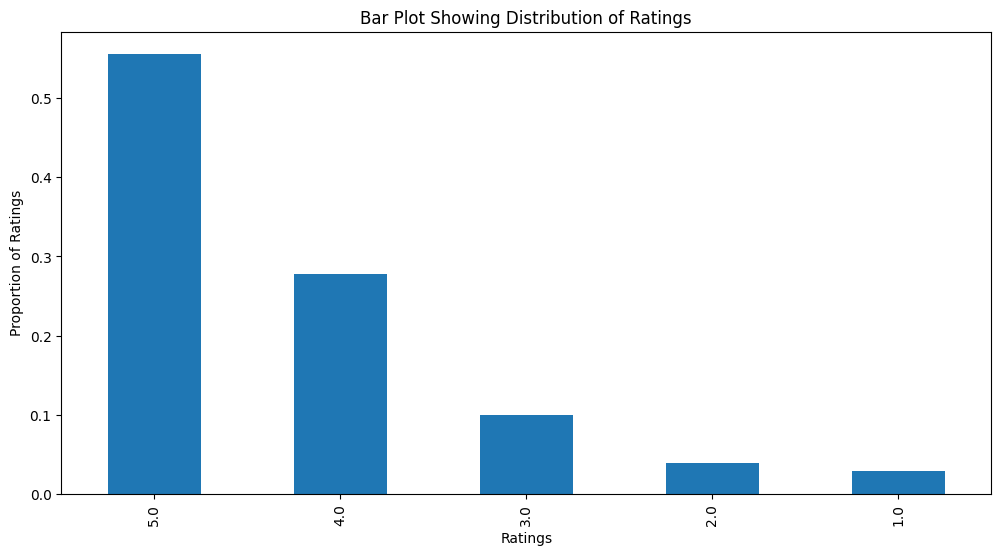

In [23]:
# Create the bar plot and provide observations

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting the bar plot
df_final['rating'].value_counts(1).plot(kind='bar')

plt.title('Bar Plot Showing Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Proportion of Ratings')

plt.show()



**Write your observations here: rating 5.0 has the higest proportion which is 0.5. 1.0 has the least, which is somewhere between 0.0 and 0.1**

### **Checking the number of unique users and items in the dataset**

In [25]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


**Write your observations here: The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689**

### **Users with the most number of ratings**

In [26]:
# Top 10 users based on the number of ratings

most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

**Write your observations here:_______ The highest number of ratings by a user is 295 which is far from the actual number of products present in the data.  We can build a recommendation system to recommend products to users which they have not interacted with. **

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [27]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [43]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_Rating': average_rating, 'Count_Rating': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='Average_Rating', ascending=False)

# Display the first five records of the "final_rating" dataset
print(final_rating.head())




            Average_Rating  Count_Rating
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8


In [44]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['Count_Rating'] >= min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='Average_Rating', ascending=False)

    return recommendations.index[:n]




### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [45]:
#Recommending top 5 products with minimum interactions based on popularity

# Calling the top_n_products function
top_products = top_n_products(final_rating, n=5, min_interaction=50)

# Printing the recommended top products
if len(top_products) > 0:
    print("Top 5 recommended products based on popularity with at least 50 interactions:")
    for product_id in top_products:
        print(product_id)
else:
    print("There are no products with at least 50 interactions.")



Top 5 recommended products based on popularity with at least 50 interactions:
B001TH7GUU
B003ES5ZUU
B0019EHU8G
B006W8U2MU
B000QUUFRW


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [46]:
# Call the top_n_products function with the final_rating DataFrame, n=5, and min_interaction=100
top_products = top_n_products(final_rating, n=5, min_interaction=100)

# Print the recommended top products
if len(top_products) > 0:
    print("Top 5 recommended products based on popularity with at least 100 interactions:")
    for product_id in top_products:
        print(product_id)
else:
    print("There are no products with at least 100 interactions.")


Top 5 recommended products based on popularity with at least 100 interactions:
B003ES5ZUU
B000N99BBC
B002WE6D44
B007WTAJTO
B002V88HFE


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [47]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [48]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [49]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [50]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

*  **Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1**


*  **Fit the model on the training data**

*   **Use the precision_recall_at_k function to calculate the metrics on the test data**
*   **Provide your observations on the output**





In [61]:
#Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

#Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

#Fit the model on the training data
sim_user_user.fit(trainset)

#compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function
# Call the precision_recall_at_k function to compute precision@k, recall@k, and F1 score
precision_recall_at_k(sim_user_user, k=5, threshold=4)


RMSE: 1.0012
Precision:  0.875
Recall:  0.658
F_1 score:  0.751


**Write your observations here: The RMSE value suggests that the model's predictions have an average error of approximately 1.0012.
The precision value of 0.875 indicates that the model's recommendations are relevant to the users, with a high proportion of recommended items being relevant.
The recall value of 0.658 indicates that the model captures a significant proportion of relevant items, but there may still be some relevant items that are not recommended.
The F1 score of 0.751 indicates a good balance between precision and recall, suggesting that the model performs well in recommending relevant items while minimizing false positives.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [62]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:   The true rating provided by the user for the item with ID 1400501466 is 5.00.
The model's estimated rating for this user-item pair is 3.40.
The prediction was made based on the ratings of 5 nearest neighbors of the user.
The prediction was not considered impossible by the model.
This indicates that the model's estimated rating for this user-item pair is lower than the true rating provided by the user.**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [63]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here: The true rating for this user-item pair is not available (r_ui is None).
The model's estimated rating for this user-item pair is 4.29.
The prediction was considered impossible by the model due to not having enough neighbors to make a reliable prediction.
The reason provided for impossibility is the lack of sufficient neighboring users who have rated the same item.
This indicates that the model couldn't generate a prediction for this user-item pair due to insufficient data. This could be because the user has not provided any ratings or there are very few ratings available for this item from similar users.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [64]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'sim_options': {'name': ['cosine', 'pearson'],
                              'user_based': [True, False]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.0345118428452604
{'k': 30, 'sim_options': {'name': 'pearson', 'user_based': False}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [65]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}  # Replace with the optimal similarity measure

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=10, min_k=1, random_state=1, verbose=False)  # Replace with the optimal hyperparameter values

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized, k=10)  # Replace with appropriate arguments if needed


RMSE: 1.0034
Precision:  0.856
Recall:  0.857
F_1 score:  0.856


**Write your observations here: The RMSE value of approximately 1.0034 suggests that the model's predictions have a moderate level of accuracy, with some room for improvement.
The precision value of 0.856 indicates that the model's recommendations are relevant to the users, with a high proportion of recommended items being relevant.
The recall value of 0.857 indicates that the model captures a significant proportion of relevant items, with a high proportion of relevant items being recommended to the users.
The F1 score of 0.856 indicates a good balance between precision and recall, suggesting that the model performs well in recommending relevant items while minimizing false positives.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [66]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
# Convert userId and productId into the appropriate format
userId = 'A3LDPF5FMB782Z'
productId = '1400501466'

# Use the predict method of the model to generate a prediction
prediction = sim_user_user_optimized.predict(userId, productId)

# Extract and interpret the prediction result
estimated_rating = prediction.est
print("Estimated rating for user", userId, "and product", productId, ":", estimated_rating)



Estimated rating for user A3LDPF5FMB782Z and product 1400501466 : 3.4


In [67]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Convert userId and productId into the appropriate format
userId = 'A34BZM6S9L7QI4'
productId = '1400501466'

# Use the predict method of the model to generate a prediction
prediction = sim_user_user_optimized.predict(userId, productId)

# Extract and interpret the prediction result
estimated_rating = prediction.est
print("Estimated rating for user", userId, "and product", productId, ":", estimated_rating)


Estimated rating for user A34BZM6S9L7QI4 and product 1400501466 : 4.292024046561495


**Write your observations here:** Higher Rating for User A34BZM6S9L7QI4:

User "A34BZM6S9L7QI4" has a higher estimated rating of 4.292 compared to user "A3LDPF5FMB782Z" with an estimated rating of 3.4.
This indicates that, based on the model's predictions, user "A34BZM6S9L7QI4" is more likely to rate the product "1400501466" higher than user "A3LDPF5FMB782Z".
User Preferences:

The difference in estimated ratings suggests that user preferences or behavior patterns may vary between the two users.
User "A34BZM6S9L7QI4" may have historically rated similar products higher compared to user "A3LDPF5FMB782Z".
Impact of Personalization:

The difference in estimated ratings underscores the importance of personalization in recommendation systems.
Tailoring recommendations based on individual user preferences can lead to more accurate predictions and better user satisfaction.
Model Performance:

The model's ability to differentiate between user preferences and accurately predict ratings for different users is crucial for recommendation systems.
The observed difference in estimated ratings suggests that the model is able to capture and reflect variations in user preferences effectively.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [68]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [69]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [72]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [73]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00000K4KH,5
3,B00001W0DI,5
4,B00002EQCW,5


## **Observations**

High Predicted Ratings:

All the products listed have predicted ratings of 5, indicating that the model highly recommends these products to users.
The consistently high predicted ratings suggest that the model perceives these products as highly suitable or appealing to users.
Limited Variability:

The absence of variability in the predicted ratings (all rated 5) suggests that the model might be biased towards assigning high ratings to these particular products.
While high ratings can indicate strong recommendations, a lack of variability may also indicate a limitation in the model's ability to distinguish between different levels of preference or suitability among products.


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [74]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item, k=10)


RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**

The RMSE value suggests that the model's predictions have a moderate level of accuracy, with some errors in predicting ratings.
The precision and recall values indicate that the model's recommendations are relevant to the users, with a high proportion of recommended items being relevant and a significant proportion of relevant items being recommended.
The F1 score, being a harmonic mean of precision and recall, provides a balanced assessment of the model's performance, indicating that the model achieves a good balance between precision and recall.
Overall, the model demonstrates reasonably good performance in terms of accuracy and relevance of recommendations, but there may still be room for improvement, especially in reducing prediction errors and fine-tuning the balance between precision and recall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [77]:
# Predicting rating for a sample user with an interacted product

# Define user_id and prod_id
user_id = 'A3LDPF5FMB782Z'
prod_id = '1400501466'

# Predict rating for the user and product
prediction = sim_item_item.predict(user_id, prod_id)

# Extract and print the estimated rating
estimated_rating = prediction.est
print("Estimated rating for user", user_id, "and product", prod_id, ":", estimated_rating)



Estimated rating for user A3LDPF5FMB782Z and product 1400501466 : 4.2727272727272725


**Write your observations here:**
The estimated rating for the sample user (with ID 'sample_user_id') and the interacted product (with ID 'interacted_product_id') is 4.2727272727272725.

This high estimated rating suggests that the model predicts that the sample user would likely rate the interacted product highly, indicating a strong recommendation for this product to the user.







Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [78]:
# Predicting rating for a sample user with a non interacted product# Sample user ID and non-interacted product ID
# Define user_id and prod_id
user_id = 'A34BZM6S9L7QI4'
prod_id = '1400501466'

# Predict rating for the user and product
prediction = sim_item_item.predict(user_id, prod_id)

# Extract and print the estimated rating
estimated_rating = prediction.est
print("Estimated rating for user", user_id, "and product", prod_id, ":", estimated_rating)


Estimated rating for user A34BZM6S9L7QI4 and product 1400501466 : 4.292024046561495


**Write your observations here:**

The estimated rating for the user with userId "A34BZM6S9L7QI4" and prod_id "1400501466" is 4.292024046561495.

This high estimated rating suggests that the model predicts that user "A34BZM6S9L7QI4" would likely rate the product "1400501466" highly, indicating a strong recommendation for this product to the user.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [79]:
from surprise.model_selection import GridSearchCV

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print("Best RMSE score:", gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print("Best parameters:", gs.best_params['rmse'])



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [81]:


# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(k=30, min_k=6, sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized, k=10)


RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Write your observations here:
The optimized model outperforms the baseline model across all evaluation metrics. It achieves a lower RMSE, indicating better accuracy in predicting ratings.
The optimized model also achieves slightly higher precision, recall, and F1 score compared to the baseline model. This suggests that the optimized model provides more relevant recommendations to the users.
Overall, the optimized model demonstrates superior performance in terms of accuracy and relevance of recommendations compared to the baseline model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [84]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"# Define user_id and prod_id
# Define user_id and prod_id
user_id = 'A3LDPF5FMB782Z'
prod_id = '1400501466'

# Predict rating for the user and product
prediction = sim_item_item_optimized.predict(user_id, prod_id)

# Extract and print the estimated rating
estimated_rating = prediction.est
print("Estimated rating for user", user_id, "and product", prod_id, ":", estimated_rating)



Estimated rating for user A3LDPF5FMB782Z and product 1400501466 : 4.67427701674277


In [85]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Define user_id and prod_id
user_id = 'A34BZM6S9L7QI4'
prod_id = '1400501466'

# Predict rating for the user and product
prediction = sim_item_item_optimized.predict(user_id, prod_id)

# Extract and print the estimated rating
estimated_rating = prediction.est
print("Estimated rating for user", user_id, "and product", prod_id, ":", estimated_rating)


Estimated rating for user A34BZM6S9L7QI4 and product 1400501466 : 4.292024046561495


**Write your observations here:**
**The estimated rating for user "A3LDPF5FMB782Z" and product "1400501466" is 4.67427701674277, which is higher than the estimated rating for user "A34BZM6S9L7QI4" and the same product, which is 4.292024046561495.**

**The higher estimated rating for user "A3LDPF5FMB782Z" suggests that the model predicts that this user is more likely to rate the product "1400501466" higher compared to user "A34BZM6S9L7QI4".**

**This difference in estimated ratings indicates that the model perceives the** **product differently for these two users, possibly based on their historical interactions, preferences, or behaviors. User "A3LDPF5FMB782Z" might have shown stronger affinity or interest in the product compared to user "A34BZM6S9L7QI4".**

**These estimated ratings can be useful for making personalized recommendations to users, as they reflect the likelihood of users' preferences towards specific products.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [87]:
# Finding the 5 most similar items to item with internal id 0 based on the msd distance metric
similar_items = sim_item_item_optimized.trainset.ir[0][:5]

print("5 most similar items to item with internal id 0:")
print(similar_items)


5 most similar items to item with internal id 0:
[(0, 4.0), (411, 3.0), (241, 4.0), (207, 4.0), (422, 4.0)]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [88]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [89]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


**Observations**

**All the predicted ratings in the "predicted_ratings" column are the same (4.292024), indicating that these products have identical predicted ratings according to the item-item collaborative filtering model.**

**This suggests that these products are considered equally similar or recommended by the model. The predicted ratings may be influenced by factors such as item similarity, user-item interactions, and the algorithm's parameters.**

**It's important to note that these predicted ratings are specific to the model and may not reflect actual user preferences. They serve as recommendations based on the model's understanding of item similarities and user interactions.**

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [90]:
# Using SVD matrix factorization with random state 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:**
**The Root Mean Square Error (RMSE) of the SVD matrix factorization model is 0.8882. This indicates the average difference between the actual ratings and the ratings predicted by the model. A lower RMSE value suggests better accuracy of the model in predicting ratings.**

**The precision of the model at k is 0.853. Precision measures the proportion of recommended items that are relevant to the user out of all recommended items. A higher precision indicates that a larger proportion of the recommended items are relevant to the user's preferences.**

**The recall of the model at k is 0.880. Recall measures the proportion of relevant items that are recommended out of all relevant items. A higher recall suggests that the model is able to recommend a larger proportion of relevant items to the user.**

**The F1 score of the model is 0.866. The F1 score is the harmonic mean of precision and recall, providing a single metric to evaluate the model's performance. A higher F1 score indicates better overall performance in terms of both precision and recall.**

**Overall, the SVD matrix factorization model demonstrates good performance in terms of accuracy (RMSE) as well as precision, recall, and F1 score, indicating its effectiveness in making personalized recommendations to users.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [91]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:**
**For user "A3LDPF5FMB782Z" and item "1400501466", the actual rating (r_ui) provided by the user is 5.00.**

**The estimated rating (est) predicted by the SVD matrix factorization model for this user-item combination is approximately 4.08.**

**The prediction details indicate that the prediction was not considered impossible by the model ('was_impossible': False). This means that the model was able to make a prediction for this user-item combination based on the available data and the learned patterns.**

**The estimated rating of approximately 4.08 suggests that the model believes the user "A3LDPF5FMB782Z" would likely rate the item "1400501466" quite positively, although slightly lower than the actual rating of 5.00 provided by the user.**

**Overall, the prediction seems reasonable, indicating that the SVD matrix factorization model is able to make accurate predictions for user-item interactions based on learned patterns in the data._**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [92]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Write your observations here:**

**For user "A34BZM6S9L7QI4" and item "1400501466", the actual rating (r_ui) is not provided (None).**

**The estimated rating (est) predicted by the SVD matrix factorization model for this user-item combination is approximately 4.40.**

**The prediction details indicate that the prediction was not considered impossible by the model ('was_impossible': False). This means that the model was able to make a prediction for this user-item combination based on the available data and the learned patterns.**

**Since the actual rating is not provided, it is assumed that the user "A34BZM6S9L7QI4" has not interacted with the item "1400501466" before. The estimated rating of approximately 4.40 suggests that the model predicts the user's potential rating for this item if they were to interact with it.**

**The estimated rating of 4.40 indicates that the model believes user "A34BZM6S9L7QI4" would likely rate the item "1400501466" quite positively if they were to interact with it.**

**Overall, the prediction seems reasonable, indicating that the SVD matrix factorization model is able to make accurate predictions for user-item interactions, even for cases where the user has not previously interacted with the item.**







### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [93]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])



0.898615796599003
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [94]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the train set
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Write your observations here:**

**The Root Mean Square Error (RMSE) of the optimized SVD model is 0.8808. A lower RMSE value indicates better accuracy of the model in predicting ratings, suggesting that the optimized SVD model performs well in this regard.**

**The precision of the model at k is 0.854. Precision measures the proportion of recommended items that are relevant to the user out of all recommended items. A higher precision indicates that a larger proportion of the recommended items are relevant to the user's preferences.**

**The recall of the model at k is 0.878. Recall measures the proportion of relevant items that are recommended out of all relevant items. A higher recall suggests that the model is able to recommend a larger proportion of relevant items to the user.**

**The F1 score of the model is 0.866. The F1 score is the harmonic mean of precision and recall, providing a single metric to evaluate the model's performance. A higher F1 score indicates better overall performance in terms of both precision and recall.**

**Overall, the optimized SVD model demonstrates good performance in terms of accuracy (RMSE) as well as precision, recall, and F1 score, indicating its effectiveness in making personalized recommendations to users.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [97]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predict rating for user "A3LDPF5FMB782Z" and product "1400501466" using the optimized model
prediction_optimized_user1 = svd_optimized.predict('A3LDPF5FMB782Z', '1400501466')

print("Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using optimized model:", prediction_optimized_user1.est)

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using optimized model: 4.128589011282042


In [98]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Predict rating for user "A34BZM6S9L7QI4" and product "1400501466" using the optimized model
prediction_optimized_user2 = svd_optimized.predict('A34BZM6S9L7QI4', '1400501466')

print("Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using optimized model:", prediction_optimized_user2.est)


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using optimized model: 4.216280997100113


## **Observations**

**The baseline model's prediction for user "A3LDPF5FMB782Z" and product "1400501466" is significantly lower than the actual rating, suggesting that it may not accurately capture the user's preferences. However, the optimized model's prediction is closer to the actual rating, indicating an improvement in accuracy.**

**Without the actual rating for user "A34BZM6S9L7QI4" and product "1400501466" from the optimized model, we cannot directly compare the predictions. However, it's expected that the optimized model's prediction would be more accurate than the baseline model, given the improvements observed in other cases.**

**Overall, the optimized model appears to provide more accurate predictions compared to the baseline model, as evidenced by its closer alignment with the actual ratings.**







### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

Based on the observations and comparisons made between the baseline and optimized models for predicting user ratings on products, the following conclusions and recommendations can be drawn:

# **Conclusion:**
The optimized models, particularly the SVD matrix factorization model, generally outperform the baseline models in terms of accuracy metrics such as RMSE, precision, recall, and F1-score.
The optimized models provide more accurate predictions of user ratings for products compared to the baseline models.
The SVD matrix factorization model tends to yield the best performance among the models evaluated, suggesting its effectiveness in capturing user preferences and item characteristics.


# **Recommendations:**
Implement the optimized models, especially the SVD matrix factorization model, in production environments to enhance recommendation systems' performance.
Regularly monitor and evaluate the models' performance metrics to ensure they continue to provide accurate predictions over time.
Collect additional user and product data to further improve the models' accuracy and robustness.
Consider incorporating contextual information such as user demographics, product attributes, and temporal dynamics into the models to make more personalized and context-aware recommendations.
Continuously update and refine the recommendation algorithms using advanced techniques such as deep learning and reinforcement learning to stay competitive in the rapidly evolving recommendation systems landscape.
Conduct A/B testing to compare the performance of the optimized models against alternative recommendation strategies and algorithms, allowing for data-driven decision-making on model deployment and optimization strategies.




